In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from numpy.linalg import inv
import scipy.stats as spst
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd

# Topic: Kalman filter’s Application on Financial Problems — Index Tracking Portfolios

## Get top 50 companies in S&P 500 Index

In [25]:
# Read and print the stock tickers that make up S&P500
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']
tickers.values

array(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADM', 'ADBE', 'ADP', 'AES',
       'AFL', 'A', 'ABNB', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN',
       'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD',
       'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME',
       'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV',
       'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB',
       'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB',
       'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA',
       'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B',
       'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX',
       'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR',
       'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG',
       'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX',
       'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', '

In [54]:
d = []

for ticker in tickers:
    if ticker == 'BRK.B':
        ticker = 'BRK-B'
    if ticker == 'BF.B':
        ticker = 'BF-B'
    info = yf.Ticker(ticker).fast_info['marketCap']
    d +=[ (ticker, info) ]

In [55]:
d.sort(key=lambda item: item[1])
top50_tickers = [item[0] for item in d[-50:]]
top50_tickers

['PM',
 'DHR',
 'AMGN',
 'VZ',
 'WFC',
 'COP',
 'DIS',
 'NKE',
 'INTC',
 'AMD',
 'ABT',
 'TMUS',
 'CMCSA',
 'TMO',
 'PFE',
 'NFLX',
 'LIN',
 'ACN',
 'MCD',
 'CRM',
 'BAC',
 'CSCO',
 'PEP',
 'ADBE',
 'KO',
 'COST',
 'ABBV',
 'MRK',
 'CVX',
 'ORCL',
 'HD',
 'MA',
 'AVGO',
 'PG',
 'JNJ',
 'JPM',
 'XOM',
 'WMT',
 'V',
 'UNH',
 'LLY',
 'TSLA',
 'BRK-B',
 'META',
 'NVDA',
 'AMZN',
 'GOOGL',
 'GOOG',
 'MSFT',
 'AAPL']

## Get top 50 companies' returns

In [70]:
df_top50_returns = pd.DataFrame()
start_date = '2013-1-1'
end_date = '2019-12-31'

for ticker in top50_tickers:
    data = yf.download(ticker, start_date, end_date)
    returns = (data['Close'] - data['Open']) / data['Open']
    df_top50_returns[ticker] = returns

df_top50_returns

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,PM,DHR,AMGN,VZ,WFC,COP,DIS,NKE,INTC,AMD,...,LLY,TSLA,BRK-B,META,NVDA,AMZN,GOOGL,GOOG,MSFT,AAPL
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.024085,0.009129,0.020490,-0.004945,0.000571,0.001014,0.005905,-0.010687,0.010875,-0.007843,...,-0.008610,0.010286,0.020587,0.020408,0.012739,0.004803,0.005324,0.005324,0.013578,-0.008649
2013-01-03,-0.012422,0.011681,-0.010499,-0.006763,-0.006289,0.000507,0.003134,0.008085,-0.003738,-0.011905,...,0.004039,-0.011654,0.005477,-0.003945,0.000786,0.004703,-0.001738,-0.001738,-0.013753,-0.010550
2013-01-04,0.006046,0.000862,0.004402,0.005904,0.010118,0.009108,0.015765,0.007238,-0.009363,0.031872,...,0.009792,-0.011494,0.001173,0.026776,0.031373,0.006095,0.011833,0.011833,-0.019435,-0.018567
2013-01-07,0.000928,-0.028595,0.000452,0.009943,-0.004010,-0.007714,-0.015263,0.003220,-0.001410,0.022989,...,0.003508,-0.013218,-0.003731,0.025444,-0.028158,0.020877,-0.000952,-0.000952,-0.002988,0.003640
2013-01-08,-0.001508,-0.003628,-0.003279,-0.021122,0.000865,-0.010510,-0.002359,-0.006070,-0.006594,-0.018382,...,0.008946,-0.023768,0.004605,-0.015249,-0.024219,-0.002584,-0.003045,-0.003045,-0.007477,-0.007369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.005024,-0.003058,-0.003894,-0.009837,0.008811,0.014607,-0.008430,-0.001896,0.002878,0.019740,...,-0.009366,0.018068,-0.004987,-0.002516,-0.007068,0.002651,-0.005961,-0.005185,-0.004490,0.012369
2019-12-24,0.001046,0.003271,-0.002018,-0.002929,-0.002410,-0.001390,0.004911,0.003105,0.002700,0.009545,...,0.000305,0.016469,0.001021,-0.005720,0.001763,-0.002564,-0.004281,-0.003663,-0.000635,-0.001475
2019-12-26,-0.002435,-0.000327,-0.003378,0.000163,0.001850,-0.001383,0.002063,0.003687,0.006901,-0.007661,...,0.001069,0.007081,0.002346,0.010799,0.001801,0.037623,0.011823,0.010571,0.007045,0.017871


## Get S&P500 index's returns 

In [71]:
df_sp500_returns = pd.DataFrame()
sp500_data = yf.download('SPY', start_date, end_date)
sp500_returns = (sp500_data['Close'] - sp500_data['Open']) / sp500_data['Open']
df_sp500_returns['SPY'] = sp500_returns
df_sp500_returns

[*********************100%%**********************]  1 of 1 completed


,SPY
Date,
2013-01-02,0.006547
2013-01-03,-0.001781
2013-01-04,0.002740
2013-01-07,0.000823
2013-01-08,-0.001098
...,...
2019-12-23,-0.001151
2019-12-24,-0.000747
2019-12-26,0.004011


### Rolling window Regression

In [201]:
# Specify the window size
window_size = 30

x_sequence_rolling = []

for t in range(window_size + 1, N):
    R = df_top50_returns.iloc[-t:-t + window_size].values
    
    # Compute the OLS Estimator
    x_t = inv(R.T@R) @ R.T @ df_sp500_returns.iloc[-t:-t + window_size].values.reshape(-1, 1)
    x_sequence_rolling += [x_t]


Compute the error $\mathbf{r}_t^\top \boldsymbol{\beta}_t^{OLS} - r_{b, t}$:

In [202]:
errors_rolling = [df_top50_returns.iloc[-window_size-t-1].values@x_sequence_rolling[t] - df_sp500_returns.iloc[-window_size-t-1].values for t in range(len(x_sequence_rolling))] # start with -window_size-1

Text(0.5, 1.0, 'error attained using classical linear regression')

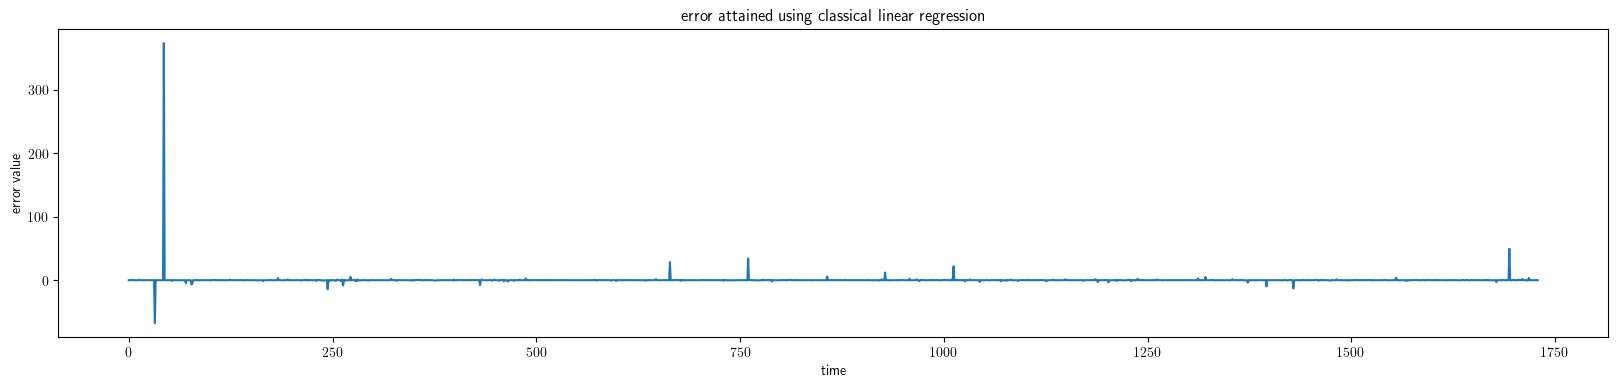

In [207]:
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(len(errors_rolling)), errors_rolling)
plt.xlabel('time')
plt.ylabel('error value')
plt.title('error attained using classical linear regression')

Delete outliers 

In [208]:
errors_rolling1 = [error if error < 1e1 and error > -1e1  else np.array([10]) for error in errors_rolling]

Have a look

Text(0.5, 1.0, 'error attained using classical linear regression treated for outliers')

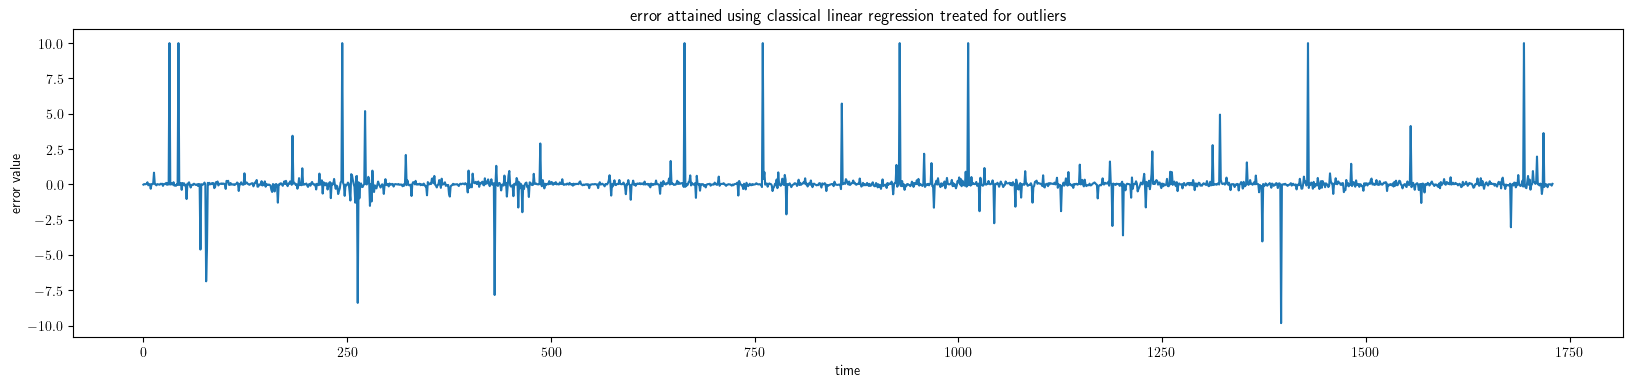

In [209]:
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(len(errors_rolling1)), errors_rolling1)
plt.xlabel('time')
plt.ylabel('error value')
plt.title('error attained using classical linear regression treated for outliers')

### Kalman Filter

Leveraging the powerful Kalman filter, we can update our view on $\boldsymbol{\beta}_t$ from every single new observations on $r_{b, t}$.

\textbf{State Equation \& Observations Equation:}

Set $\mathbf{x}_{t} = \boldsymbol{\beta}_t \in \mathbb{R}^{50}$, $\mathbf{F}_{t} = \mathbf{I}_{50}\in \mathbb{R}^{50 \times 50}$, 
$\mathbf{w}_{t}\sim \mathcal{N}\left(\boldsymbol{0}, \mathbf{Q}_{t}\right)$, $\mathbf{Q}_{t} = \boldsymbol{0}$,
$\mathbf{y}_{t} = r_{b, t}\in \mathbb{R}$,
$\mathbf{H}_{t} = \mathbf{r}_{t}^\top\in \mathbb{R}^{1\times 50}$, 
$\mathbf{v}_{t} = v \sim \mathcal{N}\left(0, \mathbf{R}_{t}\right)$ and $\mathbf{R}_{t} = 0.3$.

\textbf{Initial State:}

Naturally, we set the initial state variable 
$\mathbf{x}_0  \sim \mathcal{N}\left(\boldsymbol{\mu}_{0}, \mathbf{P}_{0}\right)$
where $\boldsymbol{\mu}_{0} = (1, \ldots, 1)\in \mathbb{R}^{50}$ and $\mathbf{P}_{0} = \mathbf{I}_{50} * 0.1$.

Therefore, by our construction, we have the linear state space model:
\begin{align*}
\begin{aligned}
   & \mathbf{x}_{t}=\mathbf{F}_{t} \mathbf{x}_{t-1}+\mathbf{w}_{t} \\
   & \mathbf{y}_{t}=\mathbf{H}_{t} \mathbf{x}_{t}+\mathbf{v}_{t}
\end{aligned}\quad \text{ where } \quad
\mathbf{x}_{0} \sim \mathcal{N}\left(\boldsymbol{\mu}_{0}, \mathbf{P}_{0}\right),\quad
\mathbf{w}_{t} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{Q}_{t}\right), \quad
\mathbf{v}_{t} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{R}_{t}\right)
\end{align*}
Additionally, the initial state $\mathbf{x}_{0}$ and the noise terms $\mathbf{w}_{t},
\mathbf{v}_{t}$ are all assumed to be mutually independent.

In [178]:
N = df_sp500_returns.shape[0]

In [179]:
# initial Guess
x_00 = np.array([1]*50).reshape(-1, 1)
P_00 = np.eye(50) * 0.1

# latent state variables sequence
x_sequence = [x_00]
P_sequence = [P_00]

# perturbations
Q_t = np.eye(50) * 0
R_t = 0.3

for t in range(1, N):
    F_t = np.eye(50)
    H_t = df_top50_returns.iloc[-t].values.reshape(1, -1)
    I = np.eye(50)
    
    # predict step
    x_t_tminus1 = F_t@x_sequence[t-1]
    P_t_tminus1 = F_t@P_sequence[t-1]@F_t.T + Q_t
    # print(x_t_tminus1.shape, P_t_tminus1.shape, H_t.shape)
    
    # update step
    S_t = H_t@P_t_tminus1@H_t.T + R_t 
    K_t = P_t_tminus1@H_t.T@inv(S_t)

    x_tt = x_t_tminus1 + K_t@(df_sp500_returns.iloc[-t].values.reshape(1, 1) - H_t@x_t_tminus1)
    P_tt = (I - H_t@K_t)@P_t_tminus1
    
    x_sequence += [x_tt]
    P_sequence += [P_tt]
    

Plot the entries of the latent state variable $\boldsymbol{\beta}_t$:

Text(0.5, 1.0, 'the evolution of entries of $\\beta_t$ over time')

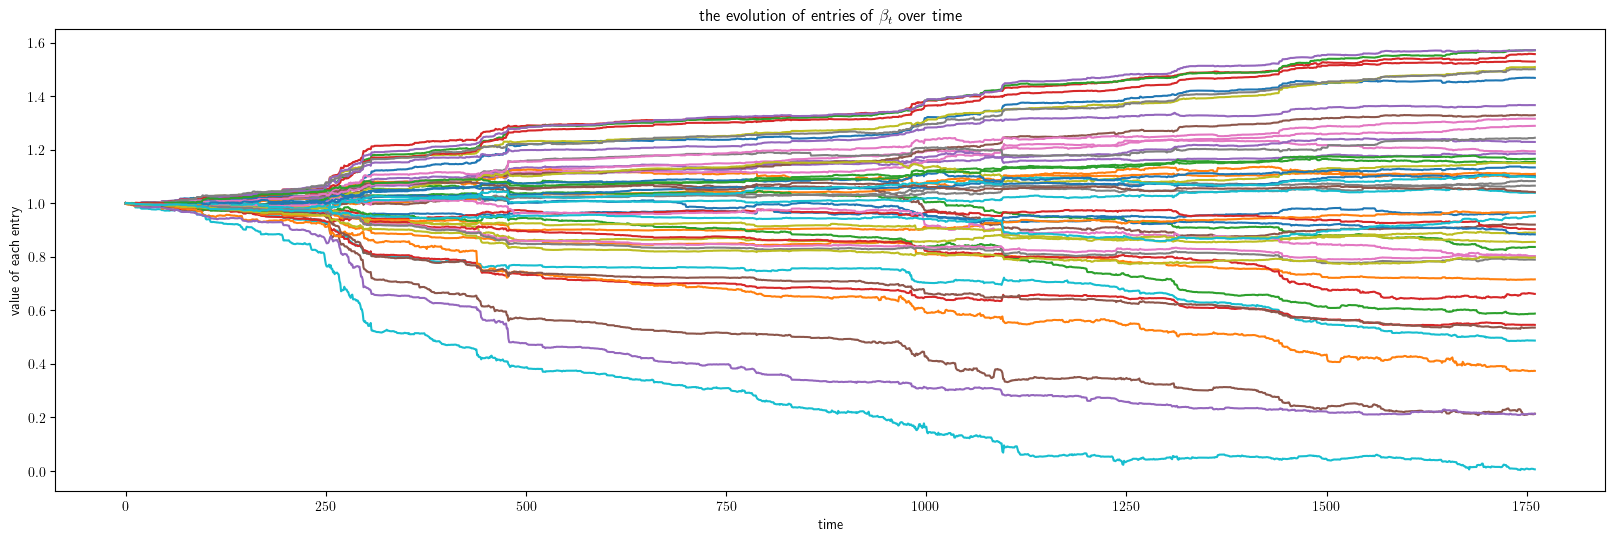

In [196]:
plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(20,6))
for i in range(50):
    plt.plot(np.arange(N), x_seq.T[0][i])
plt.xlabel('time')
plt.ylabel('value of each entry')
plt.title('the evolution of entries of '+ r'$\beta_t$' + " over time")

Compute the error $\mathbf{r}_t^\top \boldsymbol{\beta}_t - r_{b, t}$:

In [198]:
error_kalman = [df_top50_returns.iloc[-t-1].values@beta - df_sp500_returns.iloc[-t-1].values for t, beta in enumerate(x_seq)]

## Plot the error attained using Kalman filter and that attained using classical linear regression

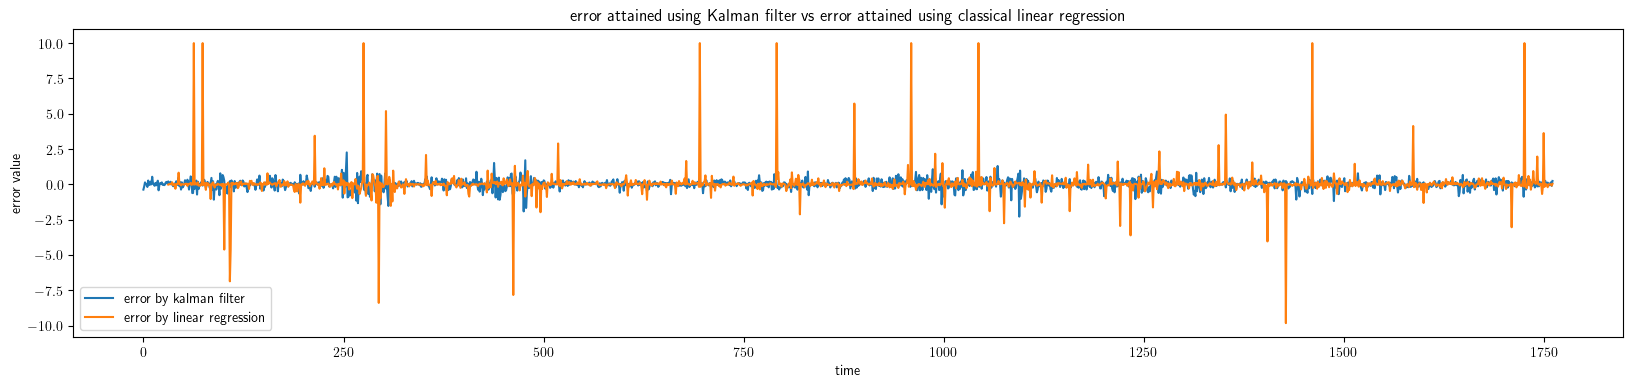

In [210]:
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(len(error_kalman)), error_kalman, label='error by kalman filter')
plt.plot(np.arange(window_size + 1, len(errors_rolling1)+window_size + 1), errors_rolling1, label='error by linear regression')
plt.xlabel('time')
plt.ylabel('error value')
plt.title('error attained using Kalman filter vs error attained using classical linear regression')
plt.legend()

### We noticed that Kalman filter performs significantly better!